# Notebook test de modelos

## Imports

In [1]:
import json
import ollama
import evaluate
from bert_score import score as bertscore
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time


import sys
import os

# Agregar el directorio raíz del proyecto al sys.path
notebook_dir = os.getcwd()  # Ruta del notebook actual
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))  # Subir un nivel al directorio raíz
sys.path.append(project_root)
# Importar la función desde rule_phrase_system.py
from src.models.rule_phrase_system import generar_resumen_pdf, generar_resumen_txt, generar_resumen_pdf_dataset_extra

c:\Users\Musatom\Documents\Universidad\Master\TFM\vtfm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuración y definición de funciones

In [9]:
# Configuración
MODELOS = ["mistral", "gemma3:4b", "gemma3:12b", "llama3.1:8b", "deepseek-r1:7b"]
N_PARTIDOS = 6

# Rutas
DATASET_PATH = "../data/dataset/dataset_updated.json"

In [3]:
# Cargar resúmenes reales (referencias)
def cargar_referencias(dataset, ids_partidos):
    with open(dataset, "r", encoding="utf-8") as f:
        dataset = json.load(f)
    referencias = {}
    for id in ids_partidos:
        resumen_ref_raw = dataset[id]["pdf_sections"].get("resumen_final", "")
        resumen_ref = str(resumen_ref_raw).strip()
        if resumen_ref:
            referencias[id] = resumen_ref
    return referencias

# Generar outputs a partir de contenido
def generar_outputs_concatenado(modelo, contenidos):
    resumen_arbitro = contenidos["arbitro"]
    resumen_asistente_1 = contenidos["asistente_1"]
    resumen_asistente_2 = contenidos["asistente_2"]
    resumen_cuarto_arbitro = contenidos["cuarto_arbitro"]

    prompt = f"""
            Eres un experto en arbitraje de fútbol. Resume el contenido que te voy a proporcionar en español, de manera profesional y concisa:

            **Árbitro**:
            {resumen_arbitro}

            **Asistente 1**:
            {resumen_asistente_1}

            **Asistente 2**:
            {resumen_asistente_2}

            **Cuarto árbitro**:
            {resumen_cuarto_arbitro}
            """
    respuesta = ollama.chat(model=modelo, messages=[
        {'role': 'system', 'content': 'Eres un experto en arbitraje de fútbol y redacción profesional en español.'},
        {'role': 'user', 'content': prompt}
    ])
    return respuesta['message']['content']

# Evaluación con ROUGE
def evaluar_rouge(predicciones, referencias):
    rouge = evaluate.load("rouge")
    return rouge.compute(predictions=predicciones, references=referencias)

# Evaluación con BERTScore
def evaluar_bertscore(predicciones, referencias):
    P, R, F1 = bertscore(predicciones, referencias, lang="es")
    return {
        "bert_precision": P.mean().item(),
        "bert_recall": R.mean().item(),
        "bert_f1": F1.mean().item()
    }

## Evaluación

In [ ]:
resumenes_pdf = generar_resumen_pdf()
ids = list(resumenes_pdf.keys())[:N_PARTIDOS]
partidos = {id: resumenes_pdf[id] for id in ids}
referencias_dict = cargar_referencias(DATASET_PATH, ids)
referencias_lista = [referencias_dict[i] for i in ids]

# Evaluación
resultados_modelos = {}
predicciones_modelos = {}

for modelo in MODELOS:
    predicciones = []
    for id in tqdm(ids, desc=f"Generando ({modelo})"):
        contenido = partidos[id]
        salida = generar_outputs_concatenado(modelo, contenido)
        predicciones.append(salida)
    predicciones_modelos[modelo] = predicciones
    rouge_scores = evaluar_rouge(predicciones, referencias_lista)
    bert_scores = evaluar_bertscore(predicciones, referencias_lista)
    resultados_modelos[modelo] = {
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"],
        "BERTScore-P": bert_scores["bert_precision"],
        "BERTScore-R": bert_scores["bert_recall"],
        "BERTScore-F1": bert_scores["bert_f1"],
    }

Generando (deepseek-r1:7b): 100%|██████████| 6/6 [01:04<00:00, 10.75s/it]


## Resultados gráficos

Para realizar el análisis, hemos empleado las siguientes métricas:

- **ROUGE**: Medidas que comparan las palabras literales del resumen generado con el resumen referencia.
    - **ROUGE-1**: Valora las coincidencias de palabras individuales, útil para saber en qué medida el modelo utiliza el mismo vocabulario clave que en el resumen referencia.
    - **ROUGE-2**: Idéntico al anterior pero comprobando las coincidencias de palabras consecutivas. Es conveniente para comprobar si el modelo es capaz de respetar las relaciones entre palabras.
    - **ROUGE-L**: Mide la longitud de la subsecuencia común más larga entre el resumen generado y el real. Es útil para comprobar si la estructrura general del texto es similar a la referencia.
- **BERTScore**: Estas métricas usan embeddings de un modelo tipo BERT para comparar el significado de palabras del resumen generado con las del resumen real.
    - **BERTScore-P (Precision)**: Mide cuántos conceptos del resumen generado están correctamente representados en el resumen real, de forma que el modelo no invente cosas y datos no encontrados en la referencia.
    - **BERTScore-R (Recall)**: Mide cuántos conceptos del resumen real aparecen en el generado. Sirve para ver si el modelo cubre la información importante.
    - **BERTScore-F1**: Básicamente, consiste en la media balanceada entre Precision y Recall, de forma que obtendremos un valor general sobre la calidad semántica del resumen generado.


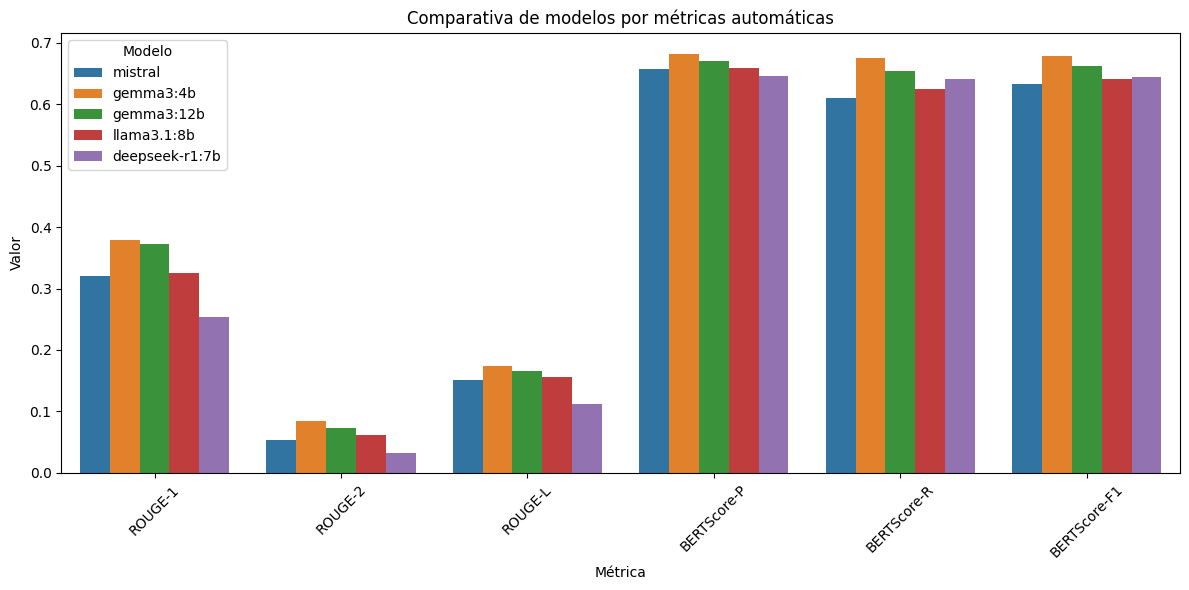

In [5]:
# Visualización
df_resultados = pd.DataFrame(resultados_modelos).T.reset_index().rename(columns={"index": "Modelo"})
df_resultados_melt = df_resultados.melt(id_vars=["Modelo"], var_name="Métrica", value_name="Valor")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_resultados_melt, x="Métrica", y="Valor", hue="Modelo")
plt.title("Comparativa de modelos por métricas automáticas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

En cuanto a los resultados, podemos observar que **Gemma3** en su **versión 4B** consigue los mejores resultados en todas y cada una de las métricas, lo que supone que sea uno de los modelos a considerar automáticamente. Sin embargo, en ninguna de estas métricas consigue una diferencia notoria con su **variante 12B**, el cual es un modelo mucho más pesado pero con una mayor capacidad de síntesis y procesamiento debido a la cantidad tan inmensa de parámetros que posee. 

El resto de modelos se quedan un poco atrás: en algunos casos, como en las métricas BERTScore, relacionadas con la semántica, el modelo **Deepseek-R1** obtiene unos resultados decentes, pero en las métricas ROUGE, es con diferencia el peor modelo. Esto nos indica que, en esencia, la información del resumen generado es similar a la referencia, por lo que cumple su cometido, pero utiliza un vocabulario bastante diferente, sobre todo en comparación al resto de modelos, por lo que puede dar lugar a una mayor confusión a la hora de relacionar los conceptos y oraciones del resumen con los hechos del informe. 

Por otro lado, tanto **Llama3.1** como **Mistral** obtienen resultados muy similares, con una mínima ventaja del primero. Están por detrás de ambas versiones de Gemma y bastante por delante de Deepseek en las métricas ROUGE, mientras que en las métricas BERTScore obtienen un rendmiento similar con este último, pero siguen en la retaguardia de Gemma. Es por ello que, como conclusión a estas pruebas, se ha decidido realizar una evaluación humana entre los **dos modelos de Gemma** para comprobar de forma manual la calidad de los resúmenes y elegir un modelo que genere los resúmenes, descartando definitivamente a **Deepseek, Mistral y Llama**, ya que obtienen un rendimiento general peor en ambos tipos de métricas.

## Evaluación con dataset ampliado

In [13]:
matches = json.load(open(DATASET_PATH, "r", encoding="utf-8"))
print(f"Total de partidos en el dataset: {len(matches)}")
matches_pdf = {key: match for key, match in matches.items() if match["txt_events"] is None or match["pdf_sections"] is not None}
matches_txt = {key: match for key, match in matches.items() if match["pdf_sections"] is None}
keys_comunes = set(matches_pdf.keys()) & set(matches_txt.keys())
matches_pdf = {key: match for key, match in matches_pdf.items() if key not in keys_comunes}
print(f"Partidos con PDF: {len(matches_pdf)}")

Total de partidos en el dataset: 123
Partidos con PDF: 48


In [ ]:
resumenes_pdf = {key: generar_resumen_pdf(match) for key,match in matches_pdf.items()}
ids = list(resumenes_pdf.keys())
partidos = {id: resumenes_pdf[id] for id in ids}
referencias_dict = cargar_referencias(DATASET_PATH, ids)
referencias_lista = [referencias_dict[i] for i in ids]

Partidos a evaluar: 48


In [21]:
# Evaluación
resultados_modelos = {}
predicciones_modelos = {}

for modelo in MODELOS:
    predicciones = []
    for id in tqdm(ids, desc=f"Generando ({modelo})"):
        contenido = partidos[id]
        salida = generar_outputs_concatenado(modelo, contenido)
        predicciones.append(salida)
    predicciones_modelos[modelo] = predicciones
    rouge_scores = evaluar_rouge(predicciones, referencias_lista)
    bert_scores = evaluar_bertscore(predicciones, referencias_lista)
    resultados_modelos[modelo] = {
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"],
        "BERTScore-P": bert_scores["bert_precision"],
        "BERTScore-R": bert_scores["bert_recall"],
        "BERTScore-F1": bert_scores["bert_f1"],
    }

Generando (deepseek-r1:7b): 100%|██████████| 48/48 [11:03<00:00, 13.82s/it]


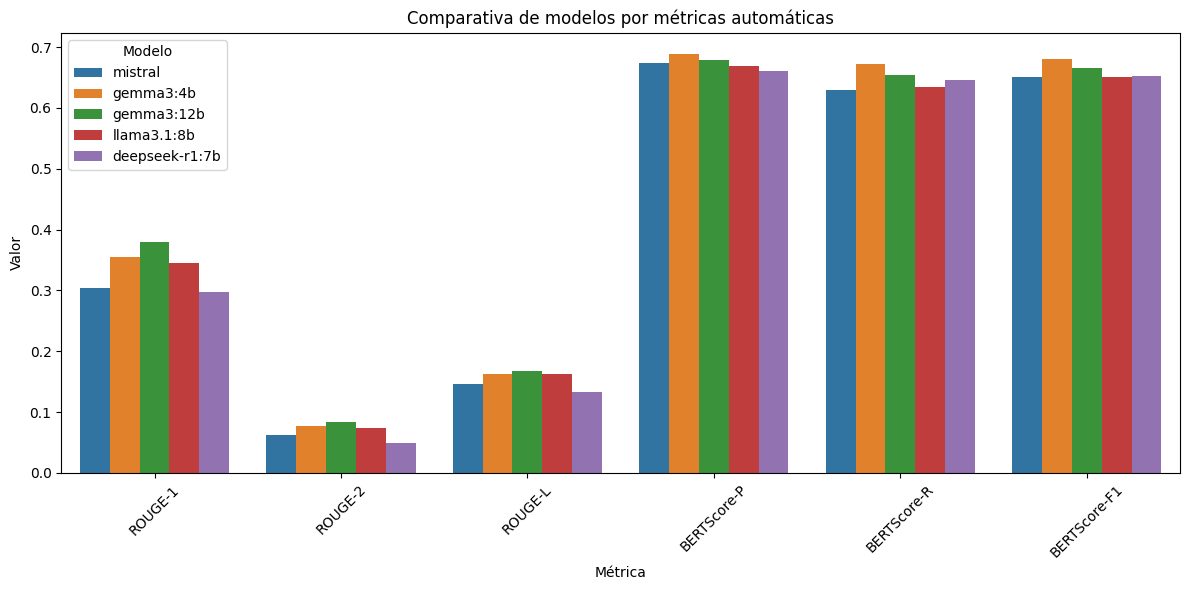

In [22]:
# Visualización
df_resultados = pd.DataFrame(resultados_modelos).T.reset_index().rename(columns={"index": "Modelo"})
df_resultados_melt = df_resultados.melt(id_vars=["Modelo"], var_name="Métrica", value_name="Valor")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_resultados_melt, x="Métrica", y="Valor", hue="Modelo")
plt.title("Comparativa de modelos por métricas automáticas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Evaluación con otro dataset

In [6]:
DATASET_EXTRA = "../data/dataset/new/dataset_extra_clean.json"
matches = json.load(open(DATASET_EXTRA, "r", encoding="utf-8"))
print(f"Total de partidos en el dataset: {len(matches)}")

Total de partidos en el dataset: 162


In [ ]:
resumenes = {key: generar_resumen_pdf_dataset_extra(match) for key,match in matches.items()}
# resumenes_txt = {key: generar_resumen_txt(match) for key,match in matches_txt.items()}
ids = list(resumenes.keys())
partidos = {id: resumenes[id] for id in ids}
referencias_dict = cargar_referencias(DATASET_EXTRA, ids)
referencias_lista = [referencias_dict[i] for i in ids]

Partidos a evaluar: 162


In [8]:
def generar_outputs_extra(modelo, contenidos):
    resumen_arbitro = contenidos["arbitro"]

    prompt = f"""
            Eres un experto en arbitraje de fútbol. Resume el contenido que te voy a proporcionar en español, de manera profesional y concisa:

            **Árbitro**:
            {resumen_arbitro}
            """
    respuesta = ollama.chat(model=modelo, messages=[
        {'role': 'system', 'content': 'Eres un experto en arbitraje de fútbol y redacción profesional en español.'},
        {'role': 'user', 'content': prompt}
    ], keep_alive=60)
    return respuesta['message']['content']

In [10]:
# Evaluación
resultados_modelos = {}
predicciones_modelos = {}

for modelo in MODELOS:
    ollama.pull(modelo)
    print(f"Modelo {modelo} descargado")
    predicciones = []
    for id in tqdm(ids, desc=f"Generando ({modelo})"):
        contenido = partidos[id]
        salida = generar_outputs_extra(modelo, contenido)
        predicciones.append(salida)
    predicciones_modelos[modelo] = predicciones
    rouge_scores = evaluar_rouge(predicciones, referencias_lista)
    bert_scores = evaluar_bertscore(predicciones, referencias_lista)
    resultados_modelos[modelo] = {
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"],
        "BERTScore-P": bert_scores["bert_precision"],
        "BERTScore-R": bert_scores["bert_recall"],
        "BERTScore-F1": bert_scores["bert_f1"],
    }

    ollama.delete(modelo)
    print(f"Modelo {modelo} eliminado")
    print("Esperando 6 minutos para evitar problemas de memoria...")
    time.sleep(120)
    print("Esperando 4 minutos para evitar problemas de memoria...")
    time.sleep(120)
    print("Esperando 2 minutos para evitar problemas de memoria...")
    time.sleep(120)
    print("Continuando...")

Modelo mistral descargado


Generando (mistral): 100%|██████████| 162/162 [13:40<00:00,  5.07s/it]


Modelo mistral eliminado
Esperando 6 minutos para evitar problemas de memoria...
Esperando 4 minutos para evitar problemas de memoria...
Esperando 2 minutos para evitar problemas de memoria...
Continuando...
Modelo gemma3:4b descargado


Generando (gemma3:4b): 100%|██████████| 162/162 [09:17<00:00,  3.44s/it]


Modelo gemma3:4b eliminado
Esperando 6 minutos para evitar problemas de memoria...
Esperando 4 minutos para evitar problemas de memoria...
Esperando 2 minutos para evitar problemas de memoria...
Continuando...
Modelo gemma3:12b descargado


Generando (gemma3:12b): 100%|██████████| 162/162 [30:47<00:00, 11.40s/it]


Modelo gemma3:12b eliminado
Esperando 6 minutos para evitar problemas de memoria...
Esperando 4 minutos para evitar problemas de memoria...
Esperando 2 minutos para evitar problemas de memoria...
Continuando...
Modelo llama3.1:8b descargado


Generando (llama3.1:8b): 100%|██████████| 162/162 [13:07<00:00,  4.86s/it]


Modelo llama3.1:8b eliminado
Esperando 6 minutos para evitar problemas de memoria...
Esperando 4 minutos para evitar problemas de memoria...
Esperando 2 minutos para evitar problemas de memoria...
Continuando...
Modelo deepseek-r1:7b descargado


Generando (deepseek-r1:7b): 100%|██████████| 162/162 [26:29<00:00,  9.81s/it]


Modelo deepseek-r1:7b eliminado
Esperando 6 minutos para evitar problemas de memoria...
Esperando 4 minutos para evitar problemas de memoria...
Esperando 2 minutos para evitar problemas de memoria...
Continuando...


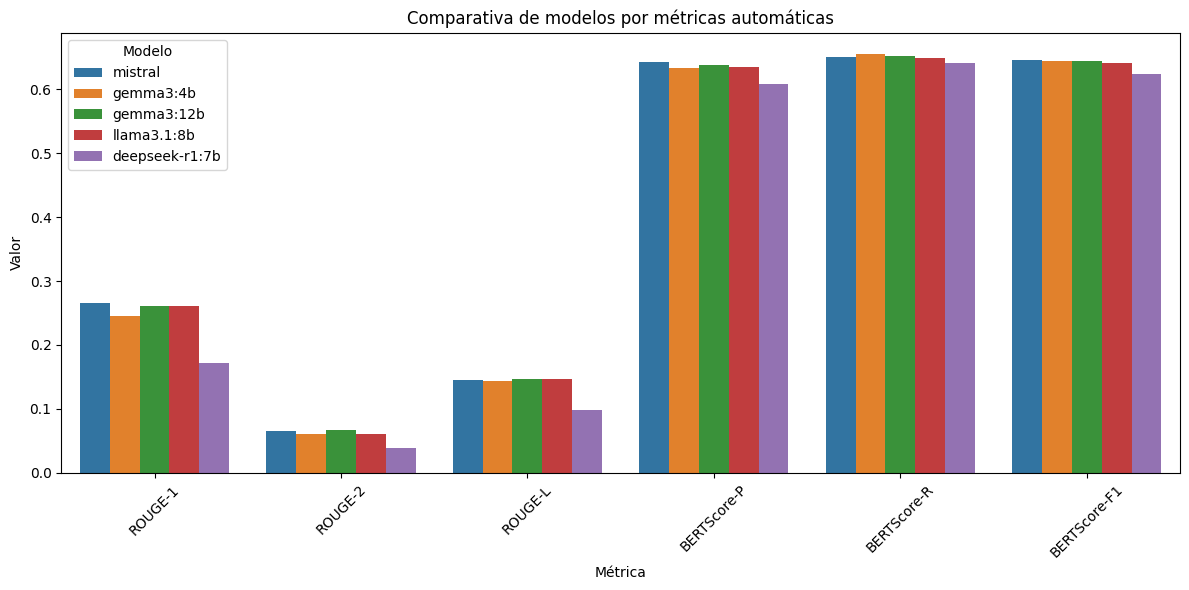

In [11]:
# Visualización
df_resultados = pd.DataFrame(resultados_modelos).T.reset_index().rename(columns={"index": "Modelo"})
df_resultados_melt = df_resultados.melt(id_vars=["Modelo"], var_name="Métrica", value_name="Valor")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_resultados_melt, x="Métrica", y="Valor", hue="Modelo")
plt.title("Comparativa de modelos por métricas automáticas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Evaluación con dataset ampliado reestructurando el prompt

In [10]:
from src.models.rule_phrase_system import generar_resumen_pdf_dataset

DATASET_PATH = os.path.join(project_root, "data", "dataset", "dataset_updated.json")
resumenes_pdf_ampliado = generar_resumen_pdf_dataset(DATASET_PATH)
ids = list(resumenes_pdf_ampliado.keys())
partidos = {id: resumenes_pdf_ampliado[id] for id in ids}
referencias_dict = cargar_referencias(DATASET_PATH, ids)
referencias_lista = [referencias_dict[i] for i in ids]

In [11]:
from src.models.prompt_gemma import prompt_arbitro, prompt_asistente_1, prompt_asistente_2, prompt_cuarto, generar_outputs
def prompt_resumenes(modelo):
    resultados_mod = []
    for pdf_id, secciones_pdf in tqdm(resumenes_pdf_ampliado.items(), desc="Procesando PDF"):
            print(f"\nProcesando informe PDF ID {pdf_id}...")

            resumen_pdf = {
                "id": pdf_id,
                "tipo": "PDF",
                "input_arbitro": secciones_pdf.get("arbitro", ""),
                "input_asistente_1": secciones_pdf.get("asistente_1", ""),
                "input_asistente_2": secciones_pdf.get("asistente_2", ""),
                "input_cuarto_arbitro": secciones_pdf.get("cuarto_arbitro", "")
            }

            output_arbitro = generar_outputs(modelo, resumen_pdf["input_arbitro"], prompt_arbitro)
            output_asistente_1 = generar_outputs(modelo, resumen_pdf["input_asistente_1"], prompt_asistente_1)
            output_asistente_2 = generar_outputs(modelo, resumen_pdf["input_asistente_2"], prompt_asistente_2)
            output_cuarto_arbitro = generar_outputs(modelo, resumen_pdf["input_cuarto_arbitro"], prompt_cuarto)

            resumen_concatenado = f"{output_arbitro} {output_asistente_1} {output_asistente_2} {output_cuarto_arbitro}".strip()

            resultados_mod.append(resumen_concatenado)
    return resultados_mod

In [ ]:
# Evaluación
resultados_modelos = {}
predicciones_modelos = {}

for modelo in MODELOS:
    print(f"Descargando modelo {modelo}...")
    ollama.pull(modelo)
    print(f"Procesando modelo {modelo}...")
    predicciones = prompt_resumenes(modelo)
    rouge_scores = evaluar_rouge(predicciones, referencias_lista)
    bert_scores = evaluar_bertscore(predicciones, referencias_lista)
    resultados_modelos[modelo] = {
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"],
        "BERTScore-P": bert_scores["bert_precision"],
        "BERTScore-R": bert_scores["bert_recall"],
        "BERTScore-F1": bert_scores["bert_f1"],
    }
    print(f"Terminado modelo {modelo}...")
    ollama.delete(modelo)
    print(f"Modelo {modelo} eliminado")

Descargando modelo mistral...
Procesando modelo mistral...


Procesando PDF:   0%|          | 0/48 [00:00<?, ?it/s]


Procesando informe PDF ID 1...


Procesando PDF:   2%|▏         | 1/48 [00:09<07:09,  9.13s/it]


Procesando informe PDF ID 3...


Procesando PDF:   4%|▍         | 2/48 [00:16<06:09,  8.02s/it]


Procesando informe PDF ID 4...


Procesando PDF:   6%|▋         | 3/48 [00:24<06:07,  8.17s/it]


Procesando informe PDF ID 5...


Procesando PDF:   8%|▊         | 4/48 [00:32<05:54,  8.05s/it]


Procesando informe PDF ID 8...


Procesando PDF:  10%|█         | 5/48 [00:40<05:46,  8.06s/it]


Procesando informe PDF ID 10...


Procesando PDF:  12%|█▎        | 6/48 [00:48<05:37,  8.03s/it]


Procesando informe PDF ID 11...


Procesando PDF:  15%|█▍        | 7/48 [00:57<05:40,  8.30s/it]


Procesando informe PDF ID 14...


Procesando PDF:  17%|█▋        | 8/48 [01:06<05:39,  8.48s/it]


Procesando informe PDF ID 17...


Procesando PDF:  19%|█▉        | 9/48 [01:13<05:14,  8.07s/it]


Procesando informe PDF ID 18...


Procesando PDF:  21%|██        | 10/48 [01:22<05:21,  8.46s/it]


Procesando informe PDF ID 21...


Procesando PDF:  23%|██▎       | 11/48 [01:34<05:43,  9.30s/it]


Procesando informe PDF ID 23...


Procesando PDF:  25%|██▌       | 12/48 [01:43<05:34,  9.28s/it]


Procesando informe PDF ID 26...


Procesando PDF:  27%|██▋       | 13/48 [01:53<05:38,  9.68s/it]


Procesando informe PDF ID 27...


Procesando PDF:  29%|██▉       | 14/48 [02:00<05:02,  8.89s/it]


Procesando informe PDF ID 29...


Procesando PDF:  31%|███▏      | 15/48 [02:07<04:32,  8.25s/it]


Procesando informe PDF ID 30...


Procesando PDF:  33%|███▎      | 16/48 [02:17<04:34,  8.59s/it]


Procesando informe PDF ID 34...


Procesando PDF:  35%|███▌      | 17/48 [02:24<04:12,  8.14s/it]


Procesando informe PDF ID 35...


Procesando PDF:  38%|███▊      | 18/48 [02:32<04:03,  8.11s/it]


Procesando informe PDF ID 36...


Procesando PDF:  40%|███▉      | 19/48 [02:40<04:00,  8.29s/it]


Procesando informe PDF ID 42...


Procesando PDF:  42%|████▏     | 20/48 [02:48<03:46,  8.09s/it]


Procesando informe PDF ID 43...


Procesando PDF:  44%|████▍     | 21/48 [02:55<03:29,  7.74s/it]


Procesando informe PDF ID 44...


Procesando PDF:  46%|████▌     | 22/48 [03:03<03:26,  7.95s/it]


Procesando informe PDF ID 49...


Procesando PDF:  48%|████▊     | 23/48 [03:11<03:13,  7.75s/it]


Procesando informe PDF ID 51...


Procesando PDF:  50%|█████     | 24/48 [03:20<03:17,  8.21s/it]


Procesando informe PDF ID 52...


Procesando PDF:  52%|█████▏    | 25/48 [03:29<03:13,  8.40s/it]


Procesando informe PDF ID 53...


Procesando PDF:  54%|█████▍    | 26/48 [03:39<03:13,  8.81s/it]


Procesando informe PDF ID 61...


Procesando PDF:  56%|█████▋    | 27/48 [03:47<03:01,  8.66s/it]


Procesando informe PDF ID 64...


Procesando PDF:  58%|█████▊    | 28/48 [03:54<02:43,  8.18s/it]


Procesando informe PDF ID 66...


Procesando PDF:  60%|██████    | 29/48 [04:04<02:43,  8.60s/it]


Procesando informe PDF ID 71...


Procesando PDF:  62%|██████▎   | 30/48 [04:11<02:30,  8.36s/it]


Procesando informe PDF ID 72...


Procesando PDF:  65%|██████▍   | 31/48 [04:19<02:18,  8.16s/it]


Procesando informe PDF ID 76...


Procesando PDF:  67%|██████▋   | 32/48 [04:27<02:11,  8.22s/it]


Procesando informe PDF ID 79...


Procesando PDF:  69%|██████▉   | 33/48 [04:39<02:17,  9.17s/it]


Procesando informe PDF ID 80...


Procesando PDF:  71%|███████   | 34/48 [04:48<02:08,  9.18s/it]


Procesando informe PDF ID 82...


Procesando PDF:  73%|███████▎  | 35/48 [04:55<01:51,  8.57s/it]


Procesando informe PDF ID 83...


Procesando PDF:  75%|███████▌  | 36/48 [05:04<01:44,  8.69s/it]


Procesando informe PDF ID 85...


Procesando PDF:  77%|███████▋  | 37/48 [05:14<01:39,  9.02s/it]


Procesando informe PDF ID 90...


Procesando PDF:  79%|███████▉  | 38/48 [05:22<01:26,  8.68s/it]


Procesando informe PDF ID 94...


Procesando PDF:  81%|████████▏ | 39/48 [05:29<01:15,  8.37s/it]


Procesando informe PDF ID 95...


Procesando PDF:  83%|████████▎ | 40/48 [05:38<01:06,  8.35s/it]


Procesando informe PDF ID 96...


Procesando PDF:  85%|████████▌ | 41/48 [05:47<00:59,  8.47s/it]


Procesando informe PDF ID 100...


Procesando PDF:  88%|████████▊ | 42/48 [05:55<00:51,  8.57s/it]


Procesando informe PDF ID 106...


Procesando PDF:  90%|████████▉ | 43/48 [06:04<00:43,  8.73s/it]


Procesando informe PDF ID 111...


Procesando PDF:  92%|█████████▏| 44/48 [06:08<00:28,  7.20s/it]


Procesando informe PDF ID 114...


Procesando PDF:  94%|█████████▍| 45/48 [06:17<00:23,  7.73s/it]


Procesando informe PDF ID 116...


Procesando PDF:  96%|█████████▌| 46/48 [06:26<00:15,  7.97s/it]


Procesando informe PDF ID 119...


Procesando PDF:  98%|█████████▊| 47/48 [06:33<00:07,  7.87s/it]


Procesando informe PDF ID 122...


Procesando PDF: 100%|██████████| 48/48 [06:40<00:00,  8.35s/it]


Terminado modelo mistral...
Modelo mistral eliminado
Descargando modelo gemma3:4b...
Procesando modelo gemma3:4b...


Procesando PDF:   0%|          | 0/48 [00:00<?, ?it/s]


Procesando informe PDF ID 1...


Procesando PDF:   2%|▏         | 1/48 [00:04<03:44,  4.77s/it]


Procesando informe PDF ID 3...


Procesando PDF:   4%|▍         | 2/48 [00:07<02:53,  3.78s/it]


Procesando informe PDF ID 4...


Procesando PDF:   6%|▋         | 3/48 [00:11<02:41,  3.58s/it]


Procesando informe PDF ID 5...


Procesando PDF:   8%|▊         | 4/48 [00:14<02:30,  3.43s/it]


Procesando informe PDF ID 8...


Procesando PDF:  10%|█         | 5/48 [00:17<02:22,  3.31s/it]


Procesando informe PDF ID 10...


Procesando PDF:  12%|█▎        | 6/48 [00:20<02:15,  3.23s/it]


Procesando informe PDF ID 11...


Procesando PDF:  15%|█▍        | 7/48 [00:24<02:18,  3.37s/it]


Procesando informe PDF ID 14...


Procesando PDF:  17%|█▋        | 8/48 [00:27<02:18,  3.47s/it]


Procesando informe PDF ID 17...


Procesando PDF:  19%|█▉        | 9/48 [00:31<02:12,  3.41s/it]


Procesando informe PDF ID 18...


Procesando PDF:  21%|██        | 10/48 [00:34<02:09,  3.41s/it]


Procesando informe PDF ID 21...


Procesando PDF:  23%|██▎       | 11/48 [00:38<02:16,  3.69s/it]


Procesando informe PDF ID 23...


Procesando PDF:  25%|██▌       | 12/48 [00:42<02:08,  3.57s/it]


Procesando informe PDF ID 26...


Procesando PDF:  27%|██▋       | 13/48 [00:45<02:00,  3.45s/it]


Procesando informe PDF ID 27...


Procesando PDF:  29%|██▉       | 14/48 [00:48<01:57,  3.45s/it]


Procesando informe PDF ID 29...


Procesando PDF:  31%|███▏      | 15/48 [00:51<01:43,  3.13s/it]


Procesando informe PDF ID 30...


Procesando PDF:  33%|███▎      | 16/48 [00:54<01:40,  3.15s/it]


Procesando informe PDF ID 34...


Procesando PDF:  35%|███▌      | 17/48 [00:57<01:40,  3.25s/it]


Procesando informe PDF ID 35...


Procesando PDF:  38%|███▊      | 18/48 [01:01<01:40,  3.34s/it]


Procesando informe PDF ID 36...


Procesando PDF:  40%|███▉      | 19/48 [01:05<01:40,  3.46s/it]


Procesando informe PDF ID 42...


Procesando PDF:  42%|████▏     | 20/48 [01:08<01:34,  3.39s/it]


Procesando informe PDF ID 43...


Procesando PDF:  44%|████▍     | 21/48 [01:11<01:24,  3.14s/it]


Procesando informe PDF ID 44...


Procesando PDF:  46%|████▌     | 22/48 [01:14<01:28,  3.39s/it]


Procesando informe PDF ID 49...


Procesando PDF:  48%|████▊     | 23/48 [01:18<01:23,  3.35s/it]


Procesando informe PDF ID 51...


Procesando PDF:  50%|█████     | 24/48 [01:21<01:22,  3.44s/it]


Procesando informe PDF ID 52...


Procesando PDF:  52%|█████▏    | 25/48 [01:25<01:22,  3.60s/it]


Procesando informe PDF ID 53...


Procesando PDF:  54%|█████▍    | 26/48 [01:29<01:19,  3.61s/it]


Procesando informe PDF ID 61...


Procesando PDF:  56%|█████▋    | 27/48 [01:32<01:14,  3.54s/it]


Procesando informe PDF ID 64...


Procesando PDF:  58%|█████▊    | 28/48 [01:36<01:10,  3.54s/it]


Procesando informe PDF ID 66...


Procesando PDF:  60%|██████    | 29/48 [01:39<01:04,  3.37s/it]


Procesando informe PDF ID 71...


Procesando PDF:  62%|██████▎   | 30/48 [01:42<01:00,  3.34s/it]


Procesando informe PDF ID 72...


Procesando PDF:  65%|██████▍   | 31/48 [01:45<00:54,  3.23s/it]


Procesando informe PDF ID 76...


Procesando PDF:  67%|██████▋   | 32/48 [01:49<00:57,  3.57s/it]


Procesando informe PDF ID 79...


Procesando PDF:  69%|██████▉   | 33/48 [01:53<00:54,  3.64s/it]


Procesando informe PDF ID 80...


Procesando PDF:  71%|███████   | 34/48 [01:57<00:52,  3.73s/it]


Procesando informe PDF ID 82...


Procesando PDF:  73%|███████▎  | 35/48 [02:01<00:47,  3.67s/it]


Procesando informe PDF ID 83...


Procesando PDF:  75%|███████▌  | 36/48 [02:04<00:42,  3.55s/it]


Procesando informe PDF ID 85...


Procesando PDF:  77%|███████▋  | 37/48 [02:08<00:39,  3.62s/it]


Procesando informe PDF ID 90...


Procesando PDF:  79%|███████▉  | 38/48 [02:11<00:36,  3.61s/it]


Procesando informe PDF ID 94...


Procesando PDF:  81%|████████▏ | 39/48 [02:15<00:31,  3.51s/it]


Procesando informe PDF ID 95...


Procesando PDF:  83%|████████▎ | 40/48 [02:17<00:25,  3.24s/it]


Procesando informe PDF ID 96...


Procesando PDF:  85%|████████▌ | 41/48 [02:21<00:24,  3.49s/it]


Procesando informe PDF ID 100...


Procesando PDF:  88%|████████▊ | 42/48 [02:25<00:20,  3.46s/it]


Procesando informe PDF ID 106...


Procesando PDF:  90%|████████▉ | 43/48 [02:28<00:17,  3.52s/it]


Procesando informe PDF ID 111...


Procesando PDF:  92%|█████████▏| 44/48 [02:30<00:11,  2.93s/it]


Procesando informe PDF ID 114...


Procesando PDF:  94%|█████████▍| 45/48 [02:33<00:09,  3.11s/it]


Procesando informe PDF ID 116...


Procesando PDF:  96%|█████████▌| 46/48 [02:36<00:06,  3.07s/it]


Procesando informe PDF ID 119...


Procesando PDF:  98%|█████████▊| 47/48 [02:41<00:03,  3.39s/it]


Procesando informe PDF ID 122...


Procesando PDF: 100%|██████████| 48/48 [02:44<00:00,  3.43s/it]


Terminado modelo gemma3:4b...
Modelo gemma3:4b eliminado
Descargando modelo gemma3:12b...
Procesando modelo gemma3:12b...


Procesando PDF:   0%|          | 0/48 [00:00<?, ?it/s]


Procesando informe PDF ID 1...


Procesando PDF:   2%|▏         | 1/48 [00:31<24:18, 31.04s/it]


Procesando informe PDF ID 3...


Procesando PDF:   4%|▍         | 2/48 [00:49<18:07, 23.64s/it]


Procesando informe PDF ID 4...


Procesando PDF:   6%|▋         | 3/48 [01:06<15:22, 20.49s/it]


Procesando informe PDF ID 5...


Procesando PDF:   8%|▊         | 4/48 [01:23<14:04, 19.18s/it]


Procesando informe PDF ID 8...


Procesando PDF:  10%|█         | 5/48 [01:43<13:52, 19.37s/it]


Procesando informe PDF ID 10...


Procesando PDF:  12%|█▎        | 6/48 [02:00<13:05, 18.70s/it]


Procesando informe PDF ID 11...


Procesando PDF:  15%|█▍        | 7/48 [02:19<12:55, 18.91s/it]


Procesando informe PDF ID 14...


Procesando PDF:  17%|█▋        | 8/48 [02:38<12:29, 18.73s/it]


Procesando informe PDF ID 17...


Procesando PDF:  19%|█▉        | 9/48 [03:04<13:39, 21.01s/it]


Procesando informe PDF ID 18...


Procesando PDF:  21%|██        | 10/48 [03:23<12:57, 20.47s/it]


Procesando informe PDF ID 21...


Procesando PDF:  23%|██▎       | 11/48 [03:44<12:39, 20.54s/it]


Procesando informe PDF ID 23...


Procesando PDF:  25%|██▌       | 12/48 [04:01<11:44, 19.56s/it]


Procesando informe PDF ID 26...


Procesando PDF:  27%|██▋       | 13/48 [04:18<10:59, 18.86s/it]


Procesando informe PDF ID 27...


Procesando PDF:  29%|██▉       | 14/48 [04:38<10:51, 19.16s/it]


Procesando informe PDF ID 29...


Procesando PDF:  31%|███▏      | 15/48 [04:52<09:44, 17.72s/it]


Procesando informe PDF ID 30...


Procesando PDF:  33%|███▎      | 16/48 [05:10<09:28, 17.77s/it]


Procesando informe PDF ID 34...


Procesando PDF:  35%|███▌      | 17/48 [05:28<09:08, 17.70s/it]


Procesando informe PDF ID 35...


Procesando PDF:  38%|███▊      | 18/48 [05:47<09:04, 18.15s/it]


Procesando informe PDF ID 36...


Procesando PDF:  40%|███▉      | 19/48 [06:08<09:13, 19.09s/it]


Procesando informe PDF ID 42...


Procesando PDF:  42%|████▏     | 20/48 [06:31<09:22, 20.08s/it]


Procesando informe PDF ID 43...


Procesando PDF:  44%|████▍     | 21/48 [06:47<08:29, 18.87s/it]


Procesando informe PDF ID 44...


Procesando PDF:  46%|████▌     | 22/48 [07:07<08:19, 19.21s/it]


Procesando informe PDF ID 49...


Procesando PDF:  48%|████▊     | 23/48 [07:27<08:05, 19.42s/it]


Procesando informe PDF ID 51...


Procesando PDF:  50%|█████     | 24/48 [07:44<07:30, 18.75s/it]


Procesando informe PDF ID 52...


Procesando PDF:  52%|█████▏    | 25/48 [08:00<06:53, 18.00s/it]


Procesando informe PDF ID 53...


Procesando PDF:  54%|█████▍    | 26/48 [08:21<06:56, 18.91s/it]


Procesando informe PDF ID 61...


Procesando PDF:  56%|█████▋    | 27/48 [08:38<06:25, 18.36s/it]


Procesando informe PDF ID 64...


Procesando PDF:  58%|█████▊    | 28/48 [08:57<06:07, 18.38s/it]


Procesando informe PDF ID 66...


Procesando PDF:  60%|██████    | 29/48 [09:12<05:34, 17.59s/it]


Procesando informe PDF ID 71...


Procesando PDF:  62%|██████▎   | 30/48 [09:33<05:31, 18.44s/it]


Procesando informe PDF ID 72...


Procesando PDF:  65%|██████▍   | 31/48 [09:51<05:13, 18.45s/it]


Procesando informe PDF ID 76...


Procesando PDF:  67%|██████▋   | 32/48 [10:08<04:45, 17.85s/it]


Procesando informe PDF ID 79...


Procesando PDF:  69%|██████▉   | 33/48 [10:27<04:34, 18.27s/it]


Procesando informe PDF ID 80...


Procesando PDF:  71%|███████   | 34/48 [10:47<04:20, 18.63s/it]


Procesando informe PDF ID 82...


Procesando PDF:  73%|███████▎  | 35/48 [11:04<03:57, 18.28s/it]


Procesando informe PDF ID 83...


Procesando PDF:  75%|███████▌  | 36/48 [11:25<03:48, 19.03s/it]


Procesando informe PDF ID 85...


Procesando PDF:  77%|███████▋  | 37/48 [11:40<03:18, 18.04s/it]


Procesando informe PDF ID 90...


Procesando PDF:  79%|███████▉  | 38/48 [11:56<02:54, 17.43s/it]


Procesando informe PDF ID 94...


Procesando PDF:  81%|████████▏ | 39/48 [12:14<02:36, 17.43s/it]


Procesando informe PDF ID 95...


Procesando PDF:  83%|████████▎ | 40/48 [12:33<02:24, 18.06s/it]


Procesando informe PDF ID 96...


Procesando PDF:  85%|████████▌ | 41/48 [12:53<02:10, 18.60s/it]


Procesando informe PDF ID 100...


Procesando PDF:  88%|████████▊ | 42/48 [13:14<01:55, 19.19s/it]


Procesando informe PDF ID 106...


Procesando PDF:  90%|████████▉ | 43/48 [13:33<01:35, 19.05s/it]


Procesando informe PDF ID 111...


Procesando PDF:  92%|█████████▏| 44/48 [13:44<01:07, 16.87s/it]


Procesando informe PDF ID 114...


Procesando PDF:  94%|█████████▍| 45/48 [14:06<00:54, 18.25s/it]


Procesando informe PDF ID 116...


Procesando PDF:  96%|█████████▌| 46/48 [14:23<00:35, 17.85s/it]


Procesando informe PDF ID 119...


Procesando PDF:  98%|█████████▊| 47/48 [14:42<00:18, 18.37s/it]


Procesando informe PDF ID 122...


Procesando PDF: 100%|██████████| 48/48 [15:02<00:00, 18.81s/it]


Terminado modelo gemma3:12b...
Modelo gemma3:12b eliminado
Descargando modelo llama3.1:8b...
Procesando modelo llama3.1:8b...


Procesando PDF:   0%|          | 0/48 [00:00<?, ?it/s]


Procesando informe PDF ID 1...


Procesando PDF:   2%|▏         | 1/48 [00:18<14:13, 18.15s/it]


Procesando informe PDF ID 3...


Procesando PDF:   4%|▍         | 2/48 [00:23<08:08, 10.62s/it]


Procesando informe PDF ID 4...


Procesando PDF:   6%|▋         | 3/48 [00:30<06:34,  8.78s/it]


Procesando informe PDF ID 5...


Procesando PDF:   8%|▊         | 4/48 [00:36<05:49,  7.95s/it]


Procesando informe PDF ID 8...


Procesando PDF:  10%|█         | 5/48 [00:44<05:31,  7.71s/it]


Procesando informe PDF ID 10...


Procesando PDF:  12%|█▎        | 6/48 [00:49<04:52,  6.96s/it]


Procesando informe PDF ID 11...


Procesando PDF:  15%|█▍        | 7/48 [00:57<04:56,  7.23s/it]


Procesando informe PDF ID 14...


Procesando PDF:  17%|█▋        | 8/48 [01:03<04:35,  6.90s/it]


Procesando informe PDF ID 17...


Procesando PDF:  19%|█▉        | 9/48 [01:10<04:25,  6.82s/it]


Procesando informe PDF ID 18...


Procesando PDF:  21%|██        | 10/48 [01:16<04:14,  6.70s/it]


Procesando informe PDF ID 21...


Procesando PDF:  23%|██▎       | 11/48 [01:26<04:41,  7.62s/it]


Procesando informe PDF ID 23...


Procesando PDF:  25%|██▌       | 12/48 [01:33<04:29,  7.47s/it]


Procesando informe PDF ID 26...


Procesando PDF:  27%|██▋       | 13/48 [01:40<04:11,  7.20s/it]


Procesando informe PDF ID 27...


Procesando PDF:  29%|██▉       | 14/48 [01:46<03:52,  6.85s/it]


Procesando informe PDF ID 29...


Procesando PDF:  31%|███▏      | 15/48 [01:51<03:29,  6.34s/it]


Procesando informe PDF ID 30...


Procesando PDF:  33%|███▎      | 16/48 [01:57<03:25,  6.41s/it]


Procesando informe PDF ID 34...


Procesando PDF:  35%|███▌      | 17/48 [02:03<03:09,  6.12s/it]


Procesando informe PDF ID 35...


Procesando PDF:  38%|███▊      | 18/48 [02:09<03:07,  6.24s/it]


Procesando informe PDF ID 36...


Procesando PDF:  40%|███▉      | 19/48 [02:16<03:01,  6.27s/it]


Procesando informe PDF ID 42...


Procesando PDF:  42%|████▏     | 20/48 [02:22<02:59,  6.42s/it]


Procesando informe PDF ID 43...


Procesando PDF:  44%|████▍     | 21/48 [02:28<02:50,  6.33s/it]


Procesando informe PDF ID 44...


Procesando PDF:  46%|████▌     | 22/48 [02:35<02:45,  6.35s/it]


Procesando informe PDF ID 49...


Procesando PDF:  48%|████▊     | 23/48 [02:42<02:41,  6.45s/it]


Procesando informe PDF ID 51...


Procesando PDF:  50%|█████     | 24/48 [02:49<02:39,  6.64s/it]


Procesando informe PDF ID 52...


Procesando PDF:  52%|█████▏    | 25/48 [02:55<02:28,  6.47s/it]


Procesando informe PDF ID 53...


Procesando PDF:  54%|█████▍    | 26/48 [03:00<02:17,  6.25s/it]


Procesando informe PDF ID 61...


Procesando PDF:  56%|█████▋    | 27/48 [03:07<02:15,  6.45s/it]


Procesando informe PDF ID 64...


Procesando PDF:  58%|█████▊    | 28/48 [03:12<01:58,  5.92s/it]


Procesando informe PDF ID 66...


Procesando PDF:  60%|██████    | 29/48 [03:18<01:51,  5.88s/it]


Procesando informe PDF ID 71...


Procesando PDF:  62%|██████▎   | 30/48 [03:24<01:45,  5.88s/it]


Procesando informe PDF ID 72...


Procesando PDF:  65%|██████▍   | 31/48 [03:30<01:43,  6.10s/it]


Procesando informe PDF ID 76...


Procesando PDF:  67%|██████▋   | 32/48 [03:38<01:43,  6.47s/it]


Procesando informe PDF ID 79...


Procesando PDF:  69%|██████▉   | 33/48 [03:46<01:44,  6.94s/it]


Procesando informe PDF ID 80...


Procesando PDF:  71%|███████   | 34/48 [03:54<01:42,  7.32s/it]


Procesando informe PDF ID 82...


Procesando PDF:  73%|███████▎  | 35/48 [04:00<01:31,  7.06s/it]


Procesando informe PDF ID 83...


Procesando PDF:  75%|███████▌  | 36/48 [04:07<01:22,  6.91s/it]


Procesando informe PDF ID 85...


Procesando PDF:  77%|███████▋  | 37/48 [04:13<01:14,  6.74s/it]


Procesando informe PDF ID 90...


Procesando PDF:  79%|███████▉  | 38/48 [04:19<01:04,  6.43s/it]


Procesando informe PDF ID 94...


Procesando PDF:  81%|████████▏ | 39/48 [04:25<00:56,  6.29s/it]


Procesando informe PDF ID 95...


Procesando PDF:  83%|████████▎ | 40/48 [04:29<00:45,  5.63s/it]


Procesando informe PDF ID 96...


Procesando PDF:  85%|████████▌ | 41/48 [04:35<00:40,  5.77s/it]


Procesando informe PDF ID 100...


Procesando PDF:  88%|████████▊ | 42/48 [04:41<00:34,  5.78s/it]


Procesando informe PDF ID 106...


Procesando PDF:  90%|████████▉ | 43/48 [04:49<00:32,  6.47s/it]


Procesando informe PDF ID 111...


Procesando PDF:  92%|█████████▏| 44/48 [04:52<00:21,  5.31s/it]


Procesando informe PDF ID 114...


Procesando PDF:  94%|█████████▍| 45/48 [04:57<00:16,  5.34s/it]


Procesando informe PDF ID 116...


Procesando PDF:  96%|█████████▌| 46/48 [05:02<00:10,  5.32s/it]


Procesando informe PDF ID 119...


Procesando PDF:  98%|█████████▊| 47/48 [05:10<00:05,  5.90s/it]


Procesando informe PDF ID 122...


Procesando PDF: 100%|██████████| 48/48 [05:15<00:00,  6.57s/it]


Terminado modelo llama3.1:8b...
Modelo llama3.1:8b eliminado
Descargando modelo deepseek-r1:7b...
Procesando modelo deepseek-r1:7b...


Procesando PDF:   0%|          | 0/48 [00:00<?, ?it/s]


Procesando informe PDF ID 1...


Procesando PDF:   2%|▏         | 1/48 [00:21<16:35, 21.17s/it]


Procesando informe PDF ID 3...


Procesando PDF:   4%|▍         | 2/48 [00:40<15:17, 19.94s/it]


Procesando informe PDF ID 4...


Procesando PDF:   6%|▋         | 3/48 [00:57<14:09, 18.88s/it]


Procesando informe PDF ID 5...


Procesando PDF:   8%|▊         | 4/48 [01:18<14:27, 19.73s/it]


Procesando informe PDF ID 8...


Procesando PDF:  10%|█         | 5/48 [01:33<12:55, 18.03s/it]


Procesando informe PDF ID 10...


Procesando PDF:  12%|█▎        | 6/48 [01:48<11:50, 16.92s/it]


Procesando informe PDF ID 11...


Procesando PDF:  15%|█▍        | 7/48 [02:08<12:09, 17.79s/it]


Procesando informe PDF ID 14...


Procesando PDF:  17%|█▋        | 8/48 [02:25<11:47, 17.69s/it]


Procesando informe PDF ID 17...


Procesando PDF:  19%|█▉        | 9/48 [02:43<11:29, 17.67s/it]


Procesando informe PDF ID 18...


Procesando PDF:  21%|██        | 10/48 [03:06<12:12, 19.28s/it]


Procesando informe PDF ID 21...


Procesando PDF:  23%|██▎       | 11/48 [03:30<12:54, 20.93s/it]


Procesando informe PDF ID 23...


Procesando PDF:  25%|██▌       | 12/48 [03:56<13:25, 22.38s/it]


Procesando informe PDF ID 26...


Procesando PDF:  27%|██▋       | 13/48 [04:20<13:23, 22.97s/it]


Procesando informe PDF ID 27...


Procesando PDF:  29%|██▉       | 14/48 [04:42<12:50, 22.66s/it]


Procesando informe PDF ID 29...


Procesando PDF:  31%|███▏      | 15/48 [05:00<11:39, 21.19s/it]


Procesando informe PDF ID 30...


Procesando PDF:  33%|███▎      | 16/48 [05:20<11:01, 20.66s/it]


Procesando informe PDF ID 34...


Procesando PDF:  35%|███▌      | 17/48 [05:40<10:38, 20.59s/it]


Procesando informe PDF ID 35...


Procesando PDF:  38%|███▊      | 18/48 [06:02<10:33, 21.11s/it]


Procesando informe PDF ID 36...


Procesando PDF:  40%|███▉      | 19/48 [06:28<10:55, 22.61s/it]


Procesando informe PDF ID 42...


Procesando PDF:  42%|████▏     | 20/48 [06:48<10:11, 21.84s/it]


Procesando informe PDF ID 43...


Procesando PDF:  44%|████▍     | 21/48 [07:20<11:07, 24.73s/it]


Procesando informe PDF ID 44...


Procesando PDF:  46%|████▌     | 22/48 [07:41<10:15, 23.66s/it]


Procesando informe PDF ID 49...


Procesando PDF:  48%|████▊     | 23/48 [08:03<09:36, 23.04s/it]


Procesando informe PDF ID 51...


Procesando PDF:  50%|█████     | 24/48 [08:26<09:12, 23.00s/it]


Procesando informe PDF ID 52...


Procesando PDF:  52%|█████▏    | 25/48 [08:41<07:57, 20.74s/it]


Procesando informe PDF ID 53...


Procesando PDF:  54%|█████▍    | 26/48 [09:07<08:08, 22.20s/it]


Procesando informe PDF ID 61...


Procesando PDF:  56%|█████▋    | 27/48 [09:31<07:58, 22.79s/it]


Procesando informe PDF ID 64...


Procesando PDF:  58%|█████▊    | 28/48 [10:01<08:17, 24.90s/it]


Procesando informe PDF ID 66...


Procesando PDF:  60%|██████    | 29/48 [10:20<07:18, 23.10s/it]


Procesando informe PDF ID 71...


Procesando PDF:  62%|██████▎   | 30/48 [10:43<06:55, 23.07s/it]


Procesando informe PDF ID 72...


Procesando PDF:  65%|██████▍   | 31/48 [11:03<06:16, 22.14s/it]


Procesando informe PDF ID 76...


Procesando PDF:  67%|██████▋   | 32/48 [11:28<06:12, 23.25s/it]


Procesando informe PDF ID 79...


Procesando PDF:  69%|██████▉   | 33/48 [11:46<05:24, 21.64s/it]


Procesando informe PDF ID 80...


Procesando PDF:  71%|███████   | 34/48 [12:08<05:03, 21.67s/it]


Procesando informe PDF ID 82...


Procesando PDF:  73%|███████▎  | 35/48 [12:32<04:50, 22.35s/it]


Procesando informe PDF ID 83...


Procesando PDF:  75%|███████▌  | 36/48 [12:54<04:25, 22.11s/it]


Procesando informe PDF ID 85...


Procesando PDF:  77%|███████▋  | 37/48 [13:14<03:56, 21.52s/it]


Procesando informe PDF ID 90...


Procesando PDF:  79%|███████▉  | 38/48 [13:35<03:34, 21.46s/it]


Procesando informe PDF ID 94...


Procesando PDF:  81%|████████▏ | 39/48 [13:57<03:13, 21.50s/it]


Procesando informe PDF ID 95...


Procesando PDF:  83%|████████▎ | 40/48 [14:16<02:46, 20.83s/it]


Procesando informe PDF ID 96...


Procesando PDF:  85%|████████▌ | 41/48 [14:41<02:34, 22.01s/it]


Procesando informe PDF ID 100...


Procesando PDF:  88%|████████▊ | 42/48 [15:03<02:12, 22.13s/it]


Procesando informe PDF ID 106...


Procesando PDF:  90%|████████▉ | 43/48 [15:31<01:59, 23.88s/it]


Procesando informe PDF ID 111...


Procesando PDF:  92%|█████████▏| 44/48 [15:48<01:27, 21.78s/it]


Procesando informe PDF ID 114...


Procesando PDF:  94%|█████████▍| 45/48 [16:10<01:06, 22.02s/it]


Procesando informe PDF ID 116...


Procesando PDF:  96%|█████████▌| 46/48 [16:35<00:45, 22.88s/it]


Procesando informe PDF ID 119...


Procesando PDF:  98%|█████████▊| 47/48 [16:55<00:21, 21.96s/it]


Procesando informe PDF ID 122...


Procesando PDF: 100%|██████████| 48/48 [17:20<00:00, 21.68s/it]


Terminado modelo deepseek-r1:7b...
Modelo deepseek-r1:7b eliminado


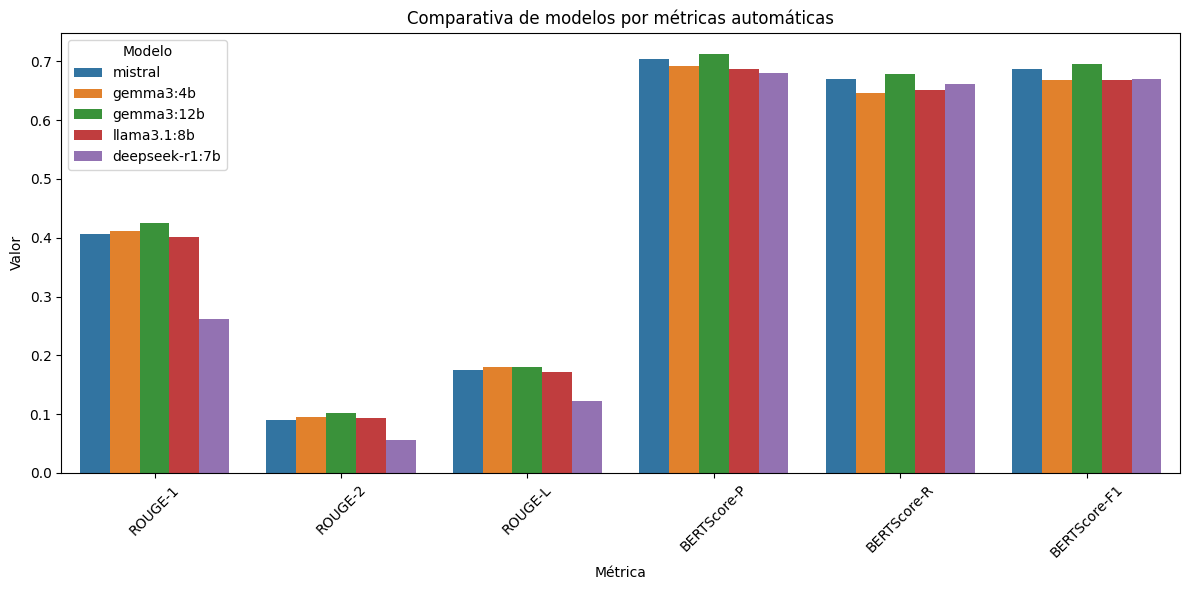

In [15]:
# Visualización
df_resultados = pd.DataFrame(resultados_modelos).T.reset_index().rename(columns={"index": "Modelo"})
df_resultados_melt = df_resultados.melt(id_vars=["Modelo"], var_name="Métrica", value_name="Valor")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_resultados_melt, x="Métrica", y="Valor", hue="Modelo")
plt.title("Comparativa de modelos por métricas automáticas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()